In [1]:
#General Use
import numpy as np
import random
import itertools

#Model Development
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

#Model Analysis / Evaluation
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
# from skimage.io import imshow
import matplotlib.pyplot as plt

#Saving models
import pickle 

In [2]:
local_train_dir = '../../data/images/Training'
image_size = (150, 150)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_train_dir, validation_split=0.2, subset="training", seed=1337, image_size=image_size,
    batch_size=32, shuffle=True
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_train_dir, validation_split=0.2, subset="validation", seed=1337, image_size=image_size,
    batch_size=32, shuffle=True
    )

Found 31501 files belonging to 2 classes.
Using 25201 files for training.
Found 31501 files belonging to 2 classes.
Using 6300 files for validation.


In [3]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [4]:
# VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Create the base model from the pre-trained model InceptionV3
base_model = VGG16(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),    
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 150, 150, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [5]:
METRICS = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.BinaryAccuracy(name='bin_accuracy')
]

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=METRICS)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Define class weights
total = 0
for image, label in train_ds:
    total += label.numpy().sum()

weight_for_0 = (1 / 1) * (total) / 2.0
weight_for_1 = (1 / 0.5) * (total) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

# Train the model
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[early_stopping], class_weight=class_weight)

2023-09-03 22:42:45.690902: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25201]
	 [[{{node Placeholder/_4}}]]
2023-09-03 22:42:45.691356: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [25201]
	 [[{{node Placeholder/_4}}]]


Epoch 1/20


2023-09-03 22:42:50.956767: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25201]
	 [[{{node Placeholder/_0}}]]
2023-09-03 22:42:50.956948: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25201]
	 [[{{node Placeholder/_0}}]]
/opt/homebrew/lib/python3.11/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


788/788 [==============================] - ETA: 0s - loss: 504.6484 - auc: 0.9959 - tp: 8905.0000 - tn: 15697.0000 - fp: 306.0000 - fn: 293.0000 - precision: 0.9668 - recall: 0.9681 - bin_accuracy: 0.9762

2023-09-03 23:54:31.495341: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6300]
	 [[{{node Placeholder/_4}}]]
2023-09-03 23:54:31.495708: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6300]
	 [[{{node Placeholder/_0}}]]


788/788 [==============================] - 4692s 6s/step - loss: 504.6484 - auc: 0.9959 - tp: 8905.0000 - tn: 15697.0000 - fp: 306.0000 - fn: 293.0000 - precision: 0.9668 - recall: 0.9681 - bin_accuracy: 0.9762 - val_loss: 0.0242 - val_auc: 0.9994 - val_tp: 2274.0000 - val_tn: 3978.0000 - val_fp: 34.0000 - val_fn: 14.0000 - val_precision: 0.9853 - val_recall: 0.9939 - val_bin_accuracy: 0.9924
Epoch 2/20
788/788 [==============================] - 1971s 3s/step - loss: 99.7229 - auc: 0.9996 - tp: 9154.0000 - tn: 15917.0000 - fp: 86.0000 - fn: 44.0000 - precision: 0.9907 - recall: 0.9952 - bin_accuracy: 0.9948 - val_loss: 0.0171 - val_auc: 0.9998 - val_tp: 2287.0000 - val_tn: 3980.0000 - val_fp: 32.0000 - val_fn: 1.0000 - val_precision: 0.9862 - val_recall: 0.9996 - val_bin_accuracy: 0.9948
Epoch 3/20
788/788 [==============================] - 2045s 3s/step - loss: 61.6078 - auc: 0.9998 - tp: 9175.0000 - tn: 15950.0000 - fp: 53.0000 - fn: 23.0000 - precision: 0.9943 - recall: 0.9975 - bin

Text(0.5, 1.0, 'Training and Validation AUC')

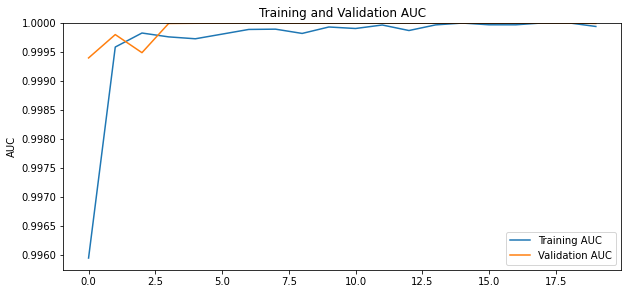

In [10]:
# plotting the metrics
fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend(loc='lower right')
plt.ylabel('AUC')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')

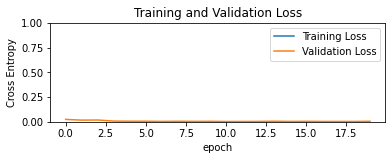

In [11]:
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

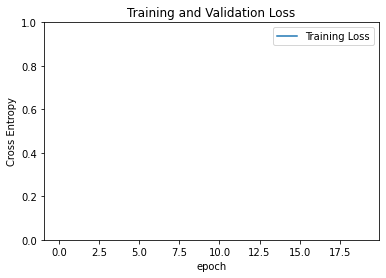

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

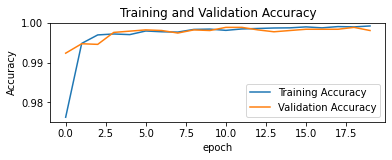

In [12]:
plt.subplot(2, 1, 1)
plt.plot(history.history['bin_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_bin_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()


In [7]:
local_test_dir = '../../data/images/Test'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_test_dir, seed=1337, image_size=image_size, batch_size=32, shuffle=True
    )

def test_classification(test_ds, model):
    results_eval = model.evaluate(test_ds, batch_size=32)

    for name, value in zip(model.metrics_names, results_eval):
        print(name, ': ', value)
    print()

    return results_eval

final_model_results = test_classification(test_ds, model)

Found 8617 files belonging to 2 classes.


2023-09-04 16:57:49.064735: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8617]
	 [[{{node Placeholder/_4}}]]
2023-09-04 16:57:49.064904: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8617]
	 [[{{node Placeholder/_0}}]]


270/270 [==============================] - 308s 1s/step - loss: 1.3948 - auc: 0.8301 - tp: 2566.0000 - tn: 4329.0000 - fp: 808.0000 - fn: 914.0000 - precision: 0.7605 - recall: 0.7374 - bin_accuracy: 0.8002
loss :  1.3947621583938599
auc :  0.8301387429237366
tp :  2566.0
tn :  4329.0
fp :  808.0
fn :  914.0
precision :  0.760521650314331
recall :  0.7373563051223755
bin_accuracy :  0.8001624941825867



In [8]:
model.save("VGG16_classifier")

INFO:tensorflow:Assets written to: VGG16_classifier/assets


INFO:tensorflow:Assets written to: VGG16_classifier/assets


In [9]:
final_model_results_train = test_classification(train_ds, model)

788/788 [==============================] - 936s 1s/step - loss: 0.0019 - auc: 1.0000 - tp: 9191.0000 - tn: 15992.0000 - fp: 11.0000 - fn: 7.0000 - precision: 0.9988 - recall: 0.9992 - bin_accuracy: 0.9993
loss :  0.0018621700583025813
auc :  0.9999982714653015
tp :  9191.0
tn :  15992.0
fp :  11.0
fn :  7.0
precision :  0.9988046288490295
recall :  0.9992389678955078
bin_accuracy :  0.9992857575416565



In [14]:
final_model_results_val = test_classification(val_ds, model)

197/197 [==============================] - 230s 1s/step - loss: 0.0051 - auc: 1.0000 - tp: 2283.0000 - tn: 4005.0000 - fp: 7.0000 - fn: 5.0000 - precision: 0.9969 - recall: 0.9978 - bin_accuracy: 0.9981
loss :  0.005099472589790821
auc :  0.9999873638153076
tp :  2283.0
tn :  4005.0
fp :  7.0
fn :  5.0
precision :  0.9969432353973389
recall :  0.9978147149085999
bin_accuracy :  0.9980952143669128

